In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise = 0.03,       #add noise to circles
                    random_state = 42)  #keep rand state

In [ ]:
print(f"first 5 X features:\n{X[:5]}")
print(f"\nfirst 5 y labels:\n{y[:5]}")

first 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

first 5 y labels:
[1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label" :y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
#check labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

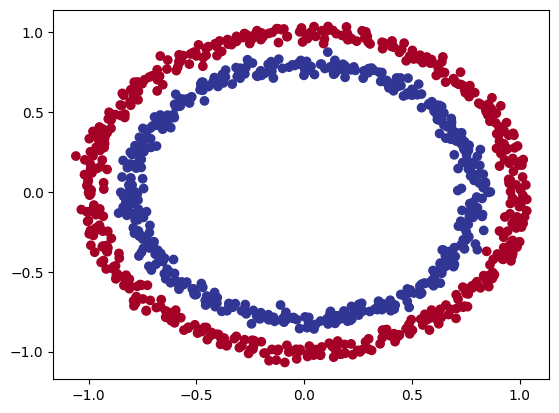

In [ ]:
#visualize
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [ ]:
#check shapes to avoid errors
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
#chec examples to clarify shape of tensors
X_sample = X[0]
y_sample = y[0]
print(f"Vals for one samp of X: {X_sample} and the same for y: {y_sample}")
print(f"shapes for one samp of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Vals for one samp of X: [0.75424625 0.23148074] and the same for y: 1
shapes for one samp of X: (2,) and the same for y: ()


In [ ]:
#convert to tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
#splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,      #20 percent test
                                                    random_state = 42)   #set seed

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
from torch import nn

#device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
#construct model class that subclasses nn.Module
class CircleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    #create 2 linear layers that can handle X and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features = 5)   #takes 2 features (X), produces 5
    self.layer_2 = nn.Linear(in_features = 5, out_features =1)  #takes 5 from before, produces 1

    #forward method
  def forward(self, x):
    #return output of layer 2, single feature, same shape as y
    return self.layer_2(self.layer_1(x)) #compute layer 1, then plug into layer 2

In [ ]:
model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#input of layer has to equal num of features as output of previous layer

In [ ]:
#replicate CircleModelv0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features=5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#sequential good for straight_forward sequential computing

In [ ]:
#make preds
untrained_preds = model_0(X_test.to(device))
print(f"Length of preds: {len(untrained_preds)}, shape : {untrained_preds.shape}")
print(f"len of test samps: {len(y_test)}, shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of preds: 200, shape : torch.Size([200, 1])
len of test samps: 200, shape: torch.Size([200])

First 10 predictions:
tensor([[0.3166],
        [0.3550],
        [0.2020],
        [0.3492],
        [0.1798],
        [0.2035],
        [0.3292],
        [0.2936],
        [0.2031],
        [0.3574]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
#create loss fn
#nn.BCELoss() has no sigmoid built in, less stable
loss_fn = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [ ]:
#calc accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() #torch.eq checks if 2 tensors are equal
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
#check first 5 outputs of forward pass on test data
y_logits = model_0(X_test.to(device))[:5]
y_logits
#logits are raw outpute of the model

tensor([[0.3166],
        [0.3550],
        [0.2020],
        [0.3492],
        [0.1798]], grad_fn=<SliceBackward0>)

In [ ]:
#apply sigmoid on logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs
#these are prediction probabilities. for binary, ideal outputs are 0 or 1
#so there is a natural decision boundary at 0.5

tensor([[0.5785],
        [0.5878],
        [0.5503],
        [0.5864],
        [0.5448]], grad_fn=<SigmoidBackward0>)

In [ ]:
#round probs into prediction labels
y_preds = torch.round(y_pred_probs)

#in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

#remove extra dim
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [ ]:
y_test[:5]    #check if same format

tensor([1., 0., 1., 0., 1.])

In [ ]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

epochs = 300

torch.manual_seed(99)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)             #nn.BCEWithLogitsLoss works with raw logits
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    if epoch %10 == 0:
      print(f"epoch: {epoch} | loss: {loss:.5f}, accuracy: {acc:.2f}% | test loss: {test_loss:.5f}, test accuracy: {test_acc:.2f}")



epoch: 0 | loss: 0.70088, accuracy: 50.00% | test loss: 0.70380, test accuracy: 50.00
epoch: 10 | loss: 0.69577, accuracy: 50.00% | test loss: 0.69950, test accuracy: 50.00
epoch: 20 | loss: 0.69417, accuracy: 53.62% | test loss: 0.69805, test accuracy: 51.50
epoch: 30 | loss: 0.69362, accuracy: 53.00% | test loss: 0.69745, test accuracy: 48.00
epoch: 40 | loss: 0.69339, accuracy: 51.88% | test loss: 0.69710, test accuracy: 47.00
epoch: 50 | loss: 0.69328, accuracy: 52.00% | test loss: 0.69684, test accuracy: 46.00
epoch: 60 | loss: 0.69321, accuracy: 51.50% | test loss: 0.69663, test accuracy: 47.00
epoch: 70 | loss: 0.69316, accuracy: 51.38% | test loss: 0.69644, test accuracy: 47.00
epoch: 80 | loss: 0.69313, accuracy: 51.25% | test loss: 0.69627, test accuracy: 47.50
epoch: 90 | loss: 0.69310, accuracy: 51.62% | test loss: 0.69612, test accuracy: 47.50
epoch: 100 | loss: 0.69308, accuracy: 51.00% | test loss: 0.69598, test accuracy: 47.50
epoch: 110 | loss: 0.69306, accuracy: 50.88

In [ ]:
import requests
from pathlib import Path

#download helper func if not already downloaded
if Path('helper_functions.py').is_file():
  print('already exists')
else:
  print('downloading')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

downloading


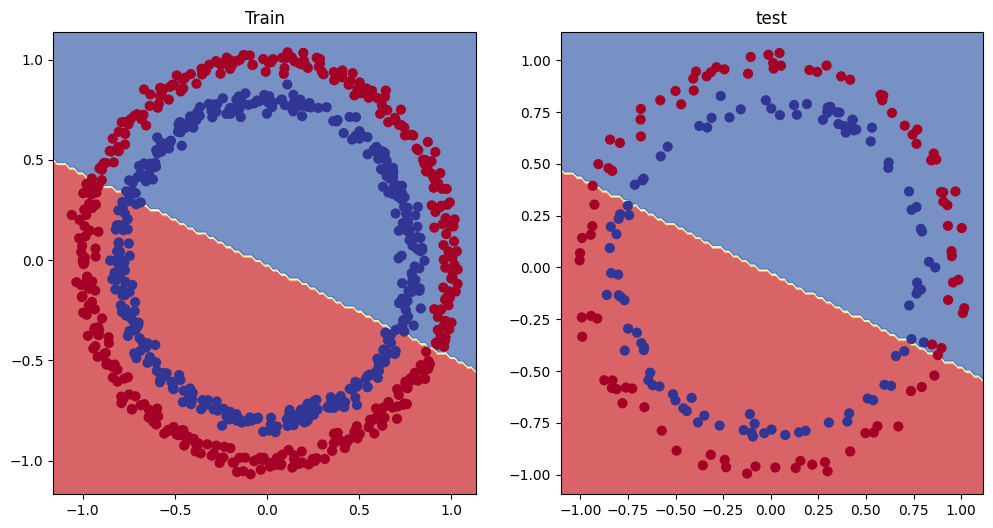

In [ ]:
#plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
# deeper means more layers
#wider means more units per layer

In [ ]:
# check if model works for linear data
w = 0.7
b = 0.3
start = 0
end = 1
step = 0.01
X_reg  = torch.arange(start, end, step).unsqueeze(dim = 1)
y_reg = w*X_reg + b

print(len(X_reg))
X_reg[:5], y_reg[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
split = int(0.8*len(X_reg))
X_train_reg, y_train_reg = X_reg[:split], y_reg[:split]
X_test_reg, y_test_reg = X_reg[split:], y_reg[split:]

print(len(X_train_reg),
    len(y_train_reg),
    len(X_test_reg),
    len(y_test_reg))

80 80 20 20


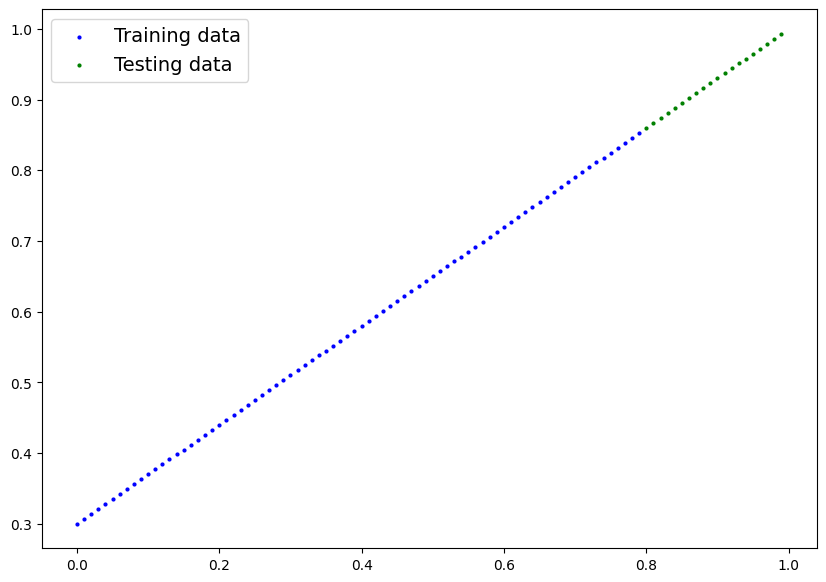

In [ ]:
plot_predictions(train_data = X_train_reg,
                 train_labels =y_train_reg,
                 test_data = X_test_reg,
                 test_labels = y_test_reg);

In [ ]:
#same type of architecture but nn.Sequential
model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features =10, out_features = 1)).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#loss and optim
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
  model_2.train()
  y_preds_reg = model_2(X_train_reg)
  loss = loss_fn(y_preds_reg, y_train_reg)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_preds_reg = model_2(X_test_reg)
    test_loss = loss_fn(test_preds_reg, y_test_reg)

    if epoch % 100 == 0 :
      print(f"epoch: {epoch} | train loss: {loss:.5f}, test loss: {test_loss:.5f}")

epoch: 0 | train loss: 0.58038, test loss: 0.52554
epoch: 100 | train loss: 0.08672, test loss: 0.25286
epoch: 200 | train loss: 0.06654, test loss: 0.18228
epoch: 300 | train loss: 0.06111, test loss: 0.15324
epoch: 400 | train loss: 0.04818, test loss: 0.11455
epoch: 500 | train loss: 0.05457, test loss: 0.13994
epoch: 600 | train loss: 0.05258, test loss: 0.09924
epoch: 700 | train loss: 0.05857, test loss: 0.13300
epoch: 800 | train loss: 0.04963, test loss: 0.13075
epoch: 900 | train loss: 0.05649, test loss: 0.11819


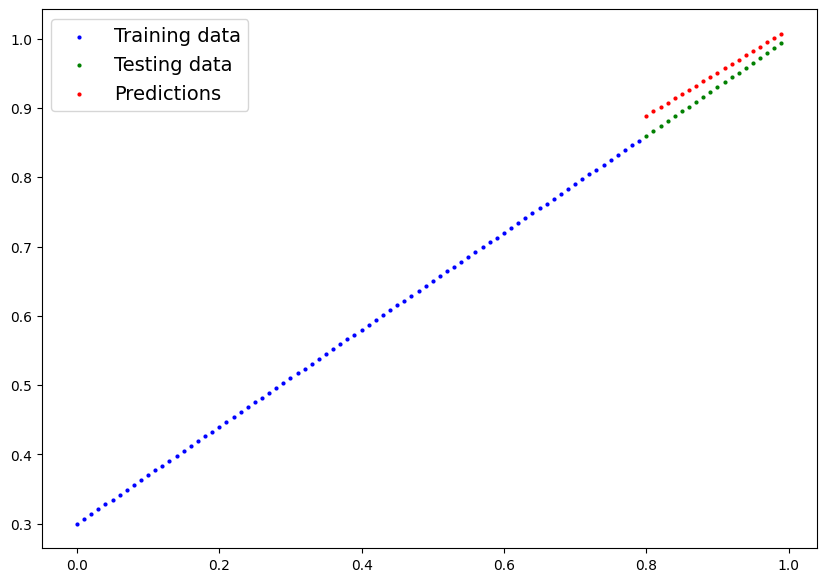

In [ ]:
plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=test_preds_reg.cpu());

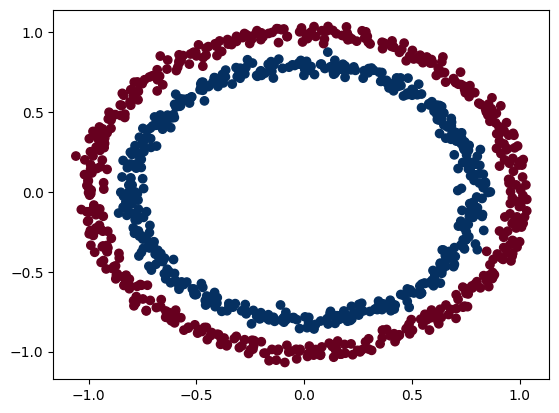

In [ ]:
#recreate non lin data
n_samples = 1000
X, y = make_circles(n_samples = 1000,
                    noise = 0.03,
                    random_state = 42,)
plt.scatter(X[:,0], X[:, 1], c = y, cmap= plt.cm.RdBu);

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features= 10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()
    #can also put sigmoid in model: self.sigmoid = nn.Sigmoid()
    #then wouldn't need to do it to the predictions

  def forward(self, x):
    #intersperse relu activation func between layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [ ]:
model_3 = CircleModelv2().to(device)
print(model_3)

CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
#loss and optim
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.1)

In [ ]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_preds)

    if epoch % 100 == 0:
      print(f"epoch: {epoch} | train loss: {loss:.5f} | train acc: {acc:.2f} | test loss: {test_loss:.5f} | test acc: {test_acc:.2f}")

epoch: 0 | train loss: 0.69295 | train acc: 50.00 | test loss: 0.69319 | test acc: 50.00
epoch: 100 | train loss: 0.69115 | train acc: 52.88 | test loss: 0.69102 | test acc: 52.50
epoch: 200 | train loss: 0.68977 | train acc: 53.37 | test loss: 0.68940 | test acc: 55.00
epoch: 300 | train loss: 0.68795 | train acc: 53.00 | test loss: 0.68723 | test acc: 56.00
epoch: 400 | train loss: 0.68517 | train acc: 52.75 | test loss: 0.68411 | test acc: 56.50
epoch: 500 | train loss: 0.68102 | train acc: 52.75 | test loss: 0.67941 | test acc: 56.50
epoch: 600 | train loss: 0.67515 | train acc: 54.50 | test loss: 0.67285 | test acc: 56.00
epoch: 700 | train loss: 0.66659 | train acc: 58.38 | test loss: 0.66322 | test acc: 59.00
epoch: 800 | train loss: 0.65160 | train acc: 64.00 | test loss: 0.64757 | test acc: 67.50
epoch: 900 | train loss: 0.62362 | train acc: 74.00 | test loss: 0.62145 | test acc: 79.00


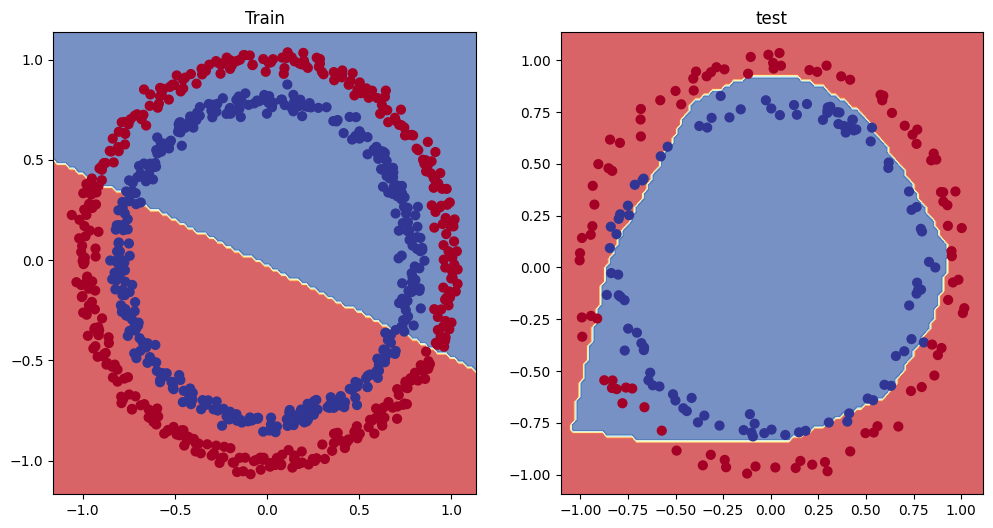

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_3, X_test, y_test)

In [ ]:
#investigate non lin
#create toy tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

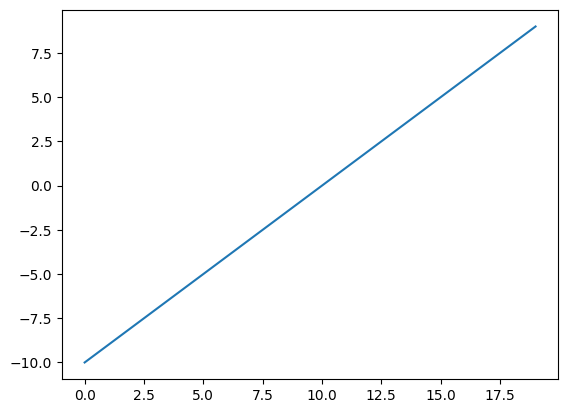

In [ ]:
#visual
plt.plot(A)

In [ ]:
#create ReLU
def relu(x):
  return torch.maximum(torch.tensor(0), x)    #inputs must be tensors
  #changes neg to 0, leaves pos untouched

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

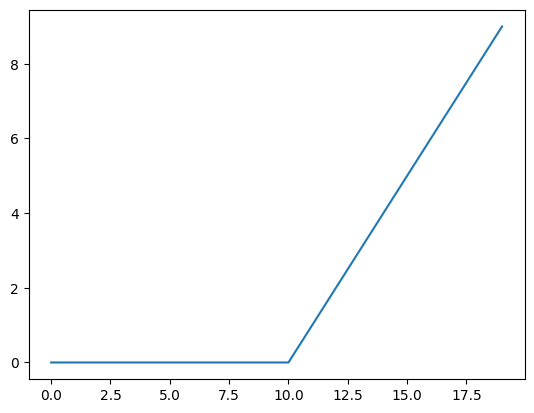

In [ ]:
plt.plot(relu(A))

In [ ]:
"""sigmoid:
1 / (1 + e^(-input))
"""
def sigmoid(x):
  return 1/(1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

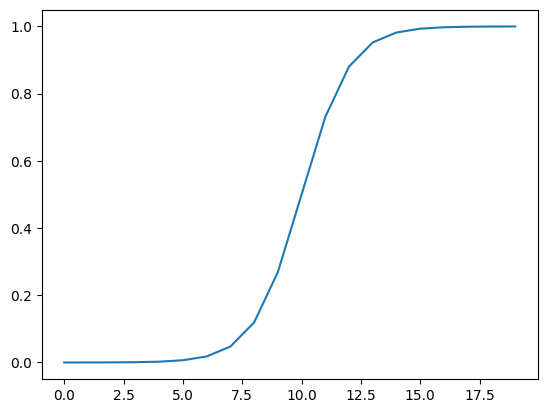

In [ ]:
plt.plot(sigmoid(A))

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


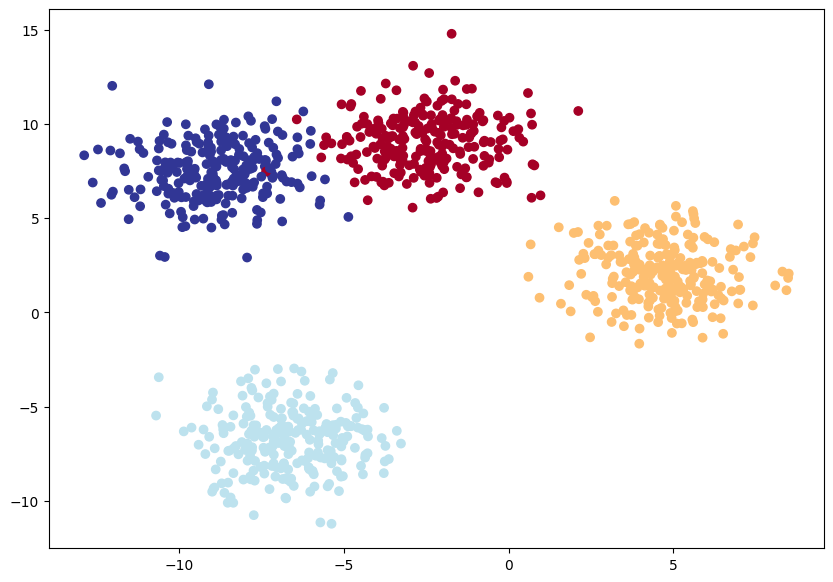

In [ ]:
#multi class
from sklearn.datasets import make_blobs

#hyperparam
NUM_CLASSES = 4
NUM_FEATURES =2
RANDOM_SEED = 42

#create multi class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES,   #x features
                           centers = NUM_CLASSES,       #y labels
                           cluster_std = 1.5,            #give clusters some noise
                           random_state = RANDOM_SEED)

#turn data to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

#split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

#plot
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c = y_blob, cmap = plt.cm.RdYlBu);

In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 9):
      """initializes all required hyper for multi class model

      Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
      super().__init__()

      self.linear_layer_stack = nn.Sequential(
          nn.Linear(in_features = input_features, out_features  = hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features = hidden_units),
          nn.ReLU(),
          nn.Linear(in_features = hidden_units, out_features= output_features),
      )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [ ]:
model_4 = BlobModel(input_features = NUM_FEATURES,
                     output_features = NUM_CLASSES,
                     hidden_units = 8).to(device)


model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr = 0.1)

In [ ]:
#single forward pass on model to check it works
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [ ]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES
#check shapes to see if model is predicting a val for each class

(torch.Size([4]), 4)

In [ ]:
#softmax turns these logits into class probs
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [ ]:
#each sample should add to 1
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
#highest val is strongest prob and ends up being the output
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


In [ ]:
torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


for epoch in range(epochs):
  model_4.train()
  blob_logits = model_4(X_blob_train)
  blob_pred = torch.softmax(blob_logits, dim = 1).argmax(dim=1)
  loss = loss_fn(blob_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train, y_pred = blob_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test, y_pred = test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


In [ ]:
#make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [ ]:
y_probs = torch.softmax(y_logits, dim = 1)

y_preds = y_probs.argmax(dim =1 )

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


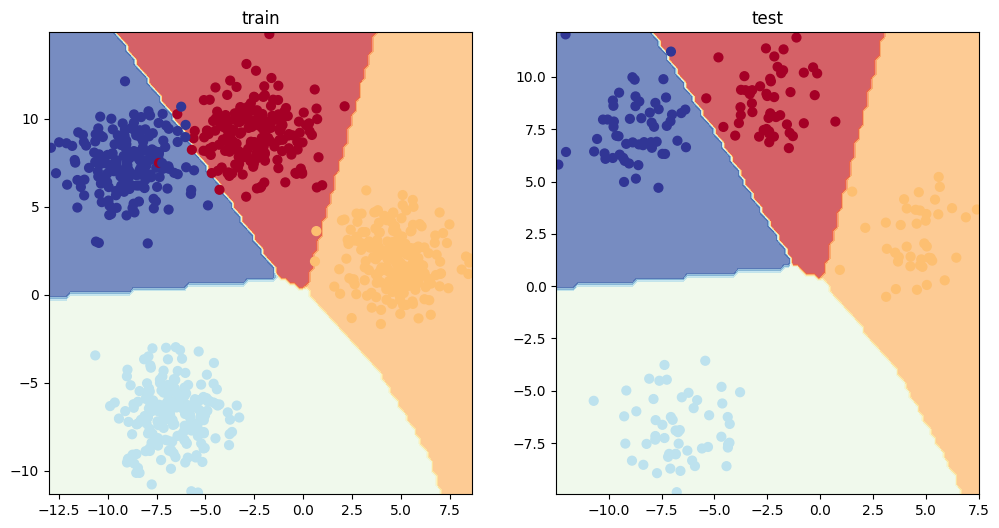

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
#adding relu layers resulted in non lin boundaries. not necessary for this model though

In [ ]:
"""

Accuracy
  Out of 100 predictions, how many does your model get correct?
  E.g. 95% accuracy means it gets 95/100 predictions correct.
  torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()
Precision
  Proportion of true positives over total number of samples.
  Higher precision leads to less false positives (model predicts 1 when it should've been 0).
  torchmetrics.Precision() or sklearn.metrics.precision_score()
Recall
  Proportion of true positives over total number of true positives and false negatives
  (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
  torchmetrics.Recall() or sklearn.metrics.recall_score()
F1-score
  Combines precision and recall into one metric. 1 is best, 0 is worst.	torchmetrics.
  F1Score() or sklearn.metrics.f1_score()
Confusion matrix
  Compares the predicted values with the true values in a tabular way,
  if 100% correct, all values in the matrix will be top left to bottom right (diagnol line).
  torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix()
Classification report
  Collection of some of the main classification metrics such as precision, recall and f1-score.
  sklearn.metrics.classification_report()
  """

"\n\nAccuracy\t\n  Out of 100 predictions, how many does your model get correct? \n  E.g. 95% accuracy means it gets 95/100 predictions correct.\t\n  torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()\nPrecision\t\n  Proportion of true positives over total number of samples. \n  Higher precision leads to less false positives (model predicts 1 when it should've been 0).\t\n  torchmetrics.Precision() or sklearn.metrics.precision_score()\nRecall\t\n  Proportion of true positives over total number of true positives and false negatives \n  (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.\t\n  torchmetrics.Recall() or sklearn.metrics.recall_score()\nF1-score\t\n  Combines precision and recall into one metric. 1 is best, 0 is worst.\ttorchmetrics.\n  F1Score() or sklearn.metrics.f1_score()\nConfusion matrix\t\n  Compares the predicted values with the true values in a tabular way, \n  if 100% correct, all values in the matrix will be top left t

In [ ]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics = 0.9.3
  from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = 'multiclass', num_classes = 4).to(device)
torchmetrics_accuracy(y_preds, y_blob_test)

ERROR: Invalid requirement: '='
Hint: = is not a valid operator. Did you mean == ?


ModuleNotFoundError: ignored